# Test 1

In [2]:
from DataManipulation.DataHandler import DEMAsDiffnDeri2Multinomial, mergeMonths
import pandas as pd
from torch.utils.data import ConcatDataset
#data = mergePeriod(1,4,beg="DAT_ASCII_EURUSD_M1_2021",dir="./eurusd2021/",dump=False)
data = mergeMonths(start=1, end=4,beg="DAT_ASCII_EURUSD_M1_2021",dir = './Data/eurusd2021/', dump=True)

data.index.name = "Date"
data.index = pd.to_datetime(data.index)

from time import time
t = time()
dc = data.copy()
dataset = DEMAsDiffnDeri2Multinomial(dc)

print([x.__name__ for x in dataset.indicators])
validEntries = dataset.raw.dropna()
predictorNames = dataset.periodDiffNames #[x.__name__+"D1" for x in dataset.indicators]+[x.__name__+"D2" for x in dataset.indicators]
ResponseName = "_y_enter_exit"

/mnt/c/Users/Luoxi/Documents/TimeSeriesRegress/DataManipulation/DataHandler.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.raw['IndicatorSupportNeuPIP'][self.raw['IndicatorSupportNeuPIP']==0] = 0.4


['dema9', 'ema20', 'ema50', 'ema100', 'ema200', 'ema300']


60397


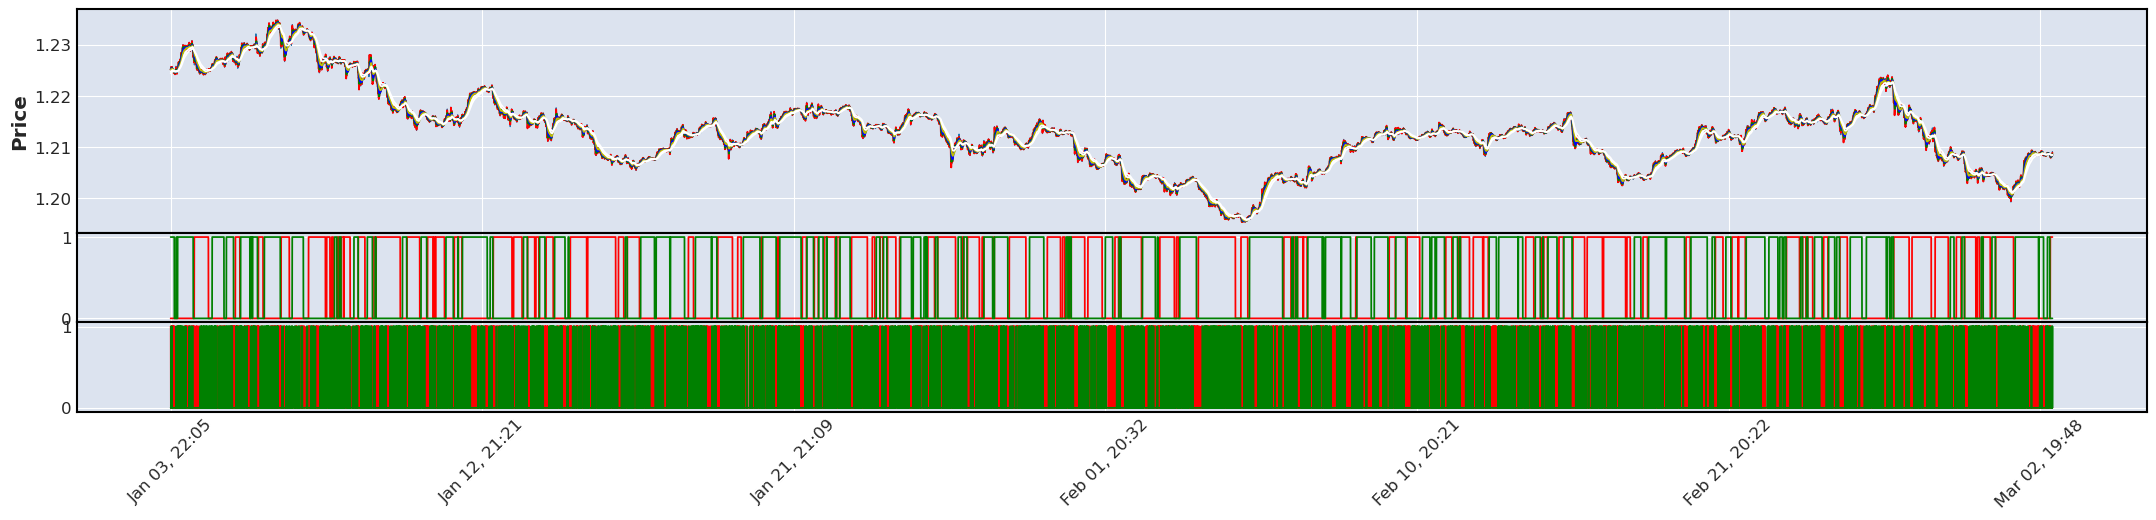

In [15]:
import mplfinance as mpf

df = dataset.raw.iloc[300:int(len(dataset.raw)/2)]
print(len(df))
apds = [
        mpf.make_addplot(df['dema9'],panel=0,color='r'),
        mpf.make_addplot(df['ema20'],panel=0,color='g'),
        mpf.make_addplot(df['ema50'],panel=0,color='b'),
        mpf.make_addplot(df['ema100'],panel=0,color='y'),
        mpf.make_addplot(df['ema200'],panel=0,color='w'),
        mpf.make_addplot(df['ema300'],panel=0,color='w'),

        #mpf.make_addplot(df['dema9D1'], panel=1,color='r'),
        #mpf.make_addplot(df['ema20D1'], panel=1,color='g'),
        #mpf.make_addplot(df['ema50D1'], panel=1,color='b'),
        #mpf.make_addplot(df['ema100D1'],panel=1,color='y'),
        #mpf.make_addplot(df['ema200D1'],panel=1,color='w'),
        #mpf.make_addplot(df['ema300D1'],panel=1,color='w'),

        mpf.make_addplot(df['IndicatorSupportNeg'], panel=1,color='r'),
        mpf.make_addplot(df['IndicatorSupportPos'], panel=1,color='g'),

        mpf.make_addplot(df['GradientSupportNeg'], panel=2,color='r'),
        mpf.make_addplot(df['GradientSupportPos'], panel=2,color='g'),
    ]

# fig, axes = mpf.plot(df,addplot=apds,figscale=14,volume=False, returnfig=True)
fig, axes = mpf.plot(df,type = 'line', figratio=(250,50),volume=False, returnfig=True,addplot=apds)#addplot=apds,figratio=(10,5),volume=False, returnfig=True)

In [39]:
fullx = validEntries[predictorNames].to_numpy()*10**5
fully = validEntries[ResponseName].to_numpy()

#windoweddataset = dataset.generateTrainingPair()
print(time()-t)

15.699672937393188


In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(fullx, fully, test_size=0.25, random_state=0)

from sklearn.linear_model import LogisticRegression
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression(solver='saga')#'liblinear')
logisticRegr.fit(x_train, y_train)

LogisticRegression(solver='saga')

In [41]:
y_pred =  logisticRegr.predict(x_test)
print(len(y_pred[y_pred==0]))
print(len(y_pred))
print(len(y_pred[y_pred==y_test]))

24016
30274
23714


In [42]:
from DataManipulation.DataHandler import DEMAsDiffnDeri2Multinomial, mergePeriod
import pandas as pd
from torch.utils.data import ConcatDataset
#data = mergePeriod(1,4,beg="DAT_ASCII_EURUSD_M1_2021",dir="./eurusd2021/",dump=False)
testdata = mergePeriod(start=5, end=5,beg="DAT_ASCII_EURUSD_M1_2021",dir = './Data/eurusd2021/', dump=True)

testdata.index.name = "Date"
testdata.index = pd.to_datetime(testdata.index)

from time import time
t = time()
testdc = testdata.copy()
testdataset = DEMAsDiffnDeri2Multinomial(testdc)

print([x.__name__ for x in testdataset.indicators])
testvalidEntries = dataset.raw.dropna()


['dema9', 'ema20', 'ema50', 'ema100', 'ema200', 'ema300']


/mnt/c/Users/Luoxi/Documents/TimeSeriesRegress/DataManipulation/DataHandler.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.raw['IndicatorSupportNeuPIP'][self.raw['IndicatorSupportNeuPIP']==0] = 0.4


In [55]:
testfullx = testvalidEntries[predictorNames].to_numpy()*10**5
testfully = testvalidEntries[ResponseName].to_numpy()
testfully_predict_label =  logisticRegr.predict(testfullx)
testfully_predict_prob  =  logisticRegr.predict_proba(testfullx)

import numpy as np
def acc_class(y_true,y_lab, label):
    idx = np.where(y_true==label)
    predicts = y_lab[idx]
    return np.sum(predicts == label)/len(predicts)
def predict_prob_false_summary(y_true,y_lab,y_prob,label):
    idx = np.where(y_true==label)
    true_lab = y_true[idx]
    predicts = y_lab[idx]
    probs    = y_prob[idx]
    wrong_idx = np.where(true_lab != predicts)
    wrong_probs = probs[wrong_idx]
    #print(wrong_probs)
    return wrong_probs
    
for l in logisticRegr.classes_:
    print(acc_class(testfully,testfully_predict_label,l))


for l in logisticRegr.classes_:
    print(acc_class(y_train,logisticRegr.predict(x_train),l))

wrong_probs = predict_prob_false_summary(testfully, testfully_predict_label, testfully_predict_prob, 0)
print(np.apply_along_axis(np.max,axis=0,arr=wrong_probs))
print(np.apply_along_axis(np.min,axis=0,arr=wrong_probs))

def prob_based_y(y_probs):
    np.app

0.4274796477820236
0.9096897776116614
0.5379714138109178
0.42773538780650416
0.9103921996199495
0.5364738166018751
[0.99918525 0.4998417  0.99927901]
[8.67343825e-09 7.20976612e-04 5.49346587e-11]


In [23]:
testfullx.shape

(121094, 6)

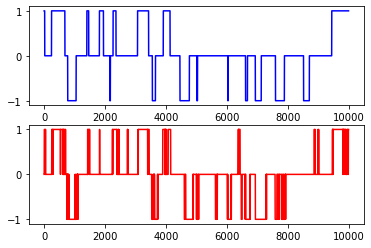

In [36]:
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(2, 1)

ax0.plot(testfully[:10000], color = 'b')
ax1.plot(test_y_pred[:10000],color = 'r')

In [37]:
#import numpy as np
#for c in logisticRegr.classes_:
#    idx = np.where(testfully,c)
#    
#    preds = test_y_pred[idx]
#    row = [preds/]
#    print([x/len(testfully[testfully==c]) for x in row])
from sklearn.metrics import confusion_matrix
print(confusion_matrix(testfully, test_y_pred))
print(confusion_matrix(y_train, logisticRegr.predict(x_train) ))
print(confusion_matrix(y_test , logisticRegr.predict(x_test) ))


[[ 7719 10338     0]
 [ 4116 77884  3616]
 [    0  8049  9372]]
[[ 5774  7725     0]
 [ 3068 58449  2685]
 [    0  6081  7038]]
[[ 1945  2613     0]
 [ 1048 19435   931]
 [    0  1968  2334]]


In [25]:
import mplfinance as mpf
testfullx
apds = [
    mpf.make_addplot(testfullx[:,0], panel=0,color='r'),
    mpf.make_addplot(testfullx[:,1], panel=0,color='g'),
    mpf.make_addplot(testfullx[:,2], panel=0,color='b'),
    mpf.make_addplot(testfullx[:,3],panel=0,color='y'),
    mpf.make_addplot(testfullx[:,4],panel=0,color='w'),
    mpf.make_addplot(testfullx[:,5],panel=0,color='w'),

]

# fig, axes = mpf.plot(df,addplot=apds,figscale=14,volume=False, returnfig=True)
fig, axes = mpf.plot(None,addplot=apds,figratio=(25,5),
                        #panel_ratios = (8,1,1) ,
                        volume = False, returnfig = True,
                        warn_too_much_data=15000,
                        #savefig='indicator_all_ind_'+str(i)+'.png'
                )

TypeError: Expect data as DataFrame